In [3]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU 사용 가능')
else:
    device = 'cpu'
    print('GPU 사용 불가')

GPU 사용 가능


In [4]:
# 학습 추이 기록

def init_log():
    plt.rc('font', size = 10)
    # 모든 log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력

    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = f'Epoch: {last(iter_log):3} | T_Loss {train_loss:5} | T_acc {train_acc:5} | V_Loss {val_loss:5} | V_acc. {val_acc:5} | Time {time_spent:5}'

    log_stack.append(log_str)

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [5]:
import numpy as np
import random

# train dataset 집어넣기
dataset = []

def load_dataset(name, index):
    forehand = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Forehand_sampling_train_dataset.npy')
    backhand = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Backhand_sampling_train_dataset.npy')
    backslice = np.load(f'../variable_dataset/training_data/{name}/{name}_B_BackSlice_sampling_train_dataset.npy')
    forevolley = np.load(f'../variable_dataset/training_data/{name}/{name}_B_ForeVolley_sampling_train_dataset.npy')
    backvolley = np.load(f'../variable_dataset/training_data/{name}/{name}_B_BackVolley_sampling_train_dataset.npy')
    smash = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Smash_sampling_train_dataset.npy')
    serve = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Serve_sampling_train_dataset.npy')
    
    for i in forehand:
        dataset.append({'key':index, 'value':i})
    for i in backhand:
        dataset.append({'key':index, 'value':i})
    for i in backslice:
        dataset.append({'key':index, 'value':i})
    for i in forevolley:
        dataset.append({'key':index, 'value':i})
    for i in backvolley:
        dataset.append({'key':index, 'value':i})
    for i in smash:
        dataset.append({'key':index, 'value':i})
    for i in serve:
        dataset.append({'key':index, 'value':i})

load_dataset('Federer', 0)
load_dataset('Nadal_inv', 1)
load_dataset('Djokovic', 2)
load_dataset('Sinner', 3)
load_dataset('Tsitsipas', 4)
load_dataset('Zverev', 5)
load_dataset('Murray', 6)
load_dataset('Alcaraz', 7)
load_dataset('Rune', 8)
load_dataset('Shapovalov_inv', 9)

random.shuffle(dataset)
print(len(dataset))

2983


In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # Pytorch에서 데이터를 불러오고, 전처리하는 클래스

class MyDataset(Dataset):
    def __init__(self, seq_data):
        self.X = []
        self.y = []
        for dic in seq_data:
            self.X.append(dic['value'])
            self.y.append(dic['key'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
            return len(self.X)

In [7]:
split_ratio = [0.8, 0.2]
train_len = round(len(dataset) * split_ratio[0])
val_len = round(len(dataset) * split_ratio[1])
print(f'{train_len}, {val_len}')

2386, 597


In [33]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, valid_data = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=16)
val_loader = DataLoader(valid_data, batch_size=16)

In [34]:
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 172, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=172, hidden_size = 256, num_layers=1, batch_first=True)
        #self.lstm3 = nn.LSTM(input_size=256, hidden_size = 512, num_layers=1, batch_first=True)
        #self.lstm4 = nn.LSTM(input_size=512, hidden_size = 256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size = 128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size = 64, num_layers=1, batch_first=True)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size = 32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        #x, _ = self.lstm3(x)
        x = self.dropout1(x)
        #x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:])
        return x

In [35]:
# 모델 초기화
import matplotlib.pyplot as plt
from torch.optim import Adam
def init_model():
    plt.rc('font', size = 10)
    global model, loss_fn, optim
    model = LSTM_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(model.parameters(), lr=0.0001)

# epoch count 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

In [36]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
import numpy as np
from tqdm import tqdm
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for 문을 나오면 1 epoch 완료)
    for _data, _label in tqdm(data_loader, desc='Training'):
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            model.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            model.eval()
    
        result = model(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로 
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출 / 첫번째 인자는 값을 두번째 인자는 index를 돌려준다.
    
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
    
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기로 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
    
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # Label == GT(실제 환경 데이터)인 개수
        acc_partial = acc_partial / len(label) # (TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Accuracy 기록

    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습 추이 그래프, 모든 GT와 Label 값 for 컨퓨전 행렬
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [37]:
# Training Initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 1000

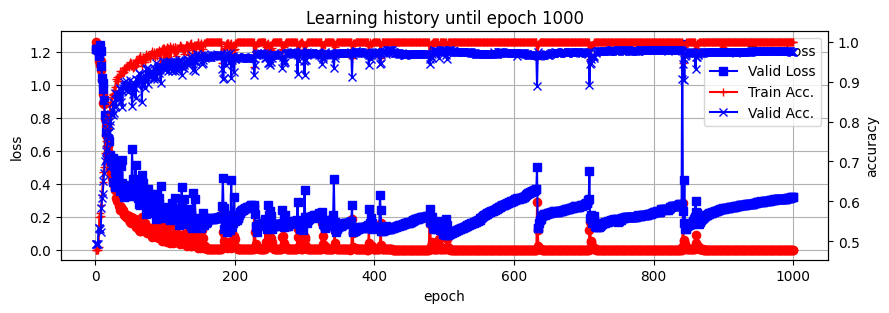

Epoch: 1000 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.318 | V_acc. 0.975 | Time 1.949
Epoch: 999 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.318 | V_acc. 0.975 | Time  1.93
Epoch: 998 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.317 | V_acc. 0.975 | Time 1.917
Epoch: 997 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.321 | V_acc. 0.975 | Time  1.95
Epoch: 996 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.315 | V_acc. 0.977 | Time 1.917
Epoch: 995 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.315 | V_acc. 0.977 | Time 1.916
Epoch: 994 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.312 | V_acc. 0.977 | Time 1.919
Epoch: 993 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.312 | V_acc. 0.977 | Time 2.056
Epoch: 992 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.312 | V_acc. 0.977 | Time 1.971
Epoch: 991 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.311 | V_acc. 0.977 | Time 1.883
Epoch: 990 | T_Loss   0.0 | T_acc   1.0 | V_Loss  0.31 | V_acc. 0.977 | Time 1.827
Epoch: 989 | T_Loss   0.0 | T_acc   1.0 | V_Loss 0.309 | V_acc. 0.977 | Time 1.801
Epo

In [38]:
# Training Iteration
import time
loss_result = []
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    loss_result.append(f'tloss : {tloss:.5} | tacc : {tacc:.5} | vloss : {vloss:.5} | vacc : {vacc:.5}')
    if tacc > 0.99 and vacc > 0.95:
        torch.save(model.state_dict(), f'./model_info/similarity_model_{swing_type}_{tloss:.5}_{tacc:.5}_{vloss:.5}_{vacc:.5}')

print('\n Training completed!')

In [ ]:
# 모델 저장하기
torch.save(model.state_dict(), './model_info/similarity_model_suppervised')

In [ ]:
cnt = 0
with open(f"similarity_model_train_result.txt", "w") as f:
    for i in loss_result:
        cnt += 1
        f.write(str(cnt))
        f.write(" ")
        f.write(str(i))
        f.write(" \n")

<b>Test

In [ ]:
model.load_state_dict(torch.load('./similarity_model_forehand_9.205e-06_1.0_0.29436_0.95227', map_location=device))

In [ ]:
test_dataset = []

def load_test_dataset(name):
    forehand = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Forehand_sampling_test_dataset.npy')
    backhand = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Backhand_sampling_test_dataset.npy')
    backslice = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_BackSlice_sampling_test_dataset.npy')
    forevolley = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_ForeVolley_sampling_test_dataset.npy')
    backvolley = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_BackVolley_sampling_test_dataset.npy')
    smash = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Smash_sampling_test_dataset.npy')
    serve = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Serve_sampling_test_dataset.npy')

    for i in forehand:
        test_dataset.append({'key':0, 'value':i})
    for i in backhand:
        test_dataset.append({'key':1, 'value':i})
    for i in backslice:
        test_dataset.append({'key':2, 'value':i})
    for i in forevolley:
        test_dataset.append({'key':3, 'value':i})
    for i in backvolley:
        test_dataset.append({'key':4, 'value':i})
    for i in smash:
        test_dataset.append({'key':5, 'value':i})
    for i in serve:
        test_dataset.append({'key':6, 'value':i})

load_test_dataset('Federer')
federer_len = len(test_dataset)

load_test_dataset('Nadal_inv')
nadal_len = len(test_dataset)

load_test_dataset('Sinner')
sinner_len = len(test_dataset)

load_test_dataset('Tsitsipas')
tsitsipas_len = len(test_dataset)

load_test_dataset('Murray')
murray_len = len(test_dataset)

load_test_dataset('Shapovalov_inv')
shapovalov_len = len(test_dataset)


print(federer_len,nadal_len,sinner_len,tsitsipas_len,murray_len,shapovalov_len)
    
test_dataset = MyDataset(test_dataset)
test_dataset = DataLoader(test_dataset)

In [ ]:
test_data_list = []

for data, label in tqdm(test_dataset):
    data = data.to(device)
    with torch.no_grad():
        classification_result = model(data)
        classification_result = F.softmax(classification_result, dim=1)
        out_result, out = torch.max(classification_result, 1)

        if out.item() == 0: 
            test_data_list.append('Federer')
        elif out.item() == 1: 
            test_data_list.append('Nadal')
        elif out.item() == 2: 
            test_data_list.append('Djokovic')
        elif out.item() == 3: 
            test_data_list.append('Sinner')
        elif out.item() == 4: 
            test_data_list.append('Tsitsipas')
        elif out.item() == 5: 
            test_data_list.append('Zverev')
        elif out.item() == 6: 
            test_data_list.append('Murray')
        elif out.item() == 7: 
            test_data_list.append('Alcaraz')
        elif out.item() == 8: 
            test_data_list.append('Rune')
        elif out.item() == 9: 
            test_data_list.append('Shapovalov')

In [ ]:
cnt = 0
check = 0

for i in test_data_list:
    cnt += 1
    if cnt <= federer_len:
        if i != 'Federer':
            check += 1
            print('Federer', i)
    elif cnt <= nadal_len:
        if i != 'Nadal':
            check += 1
            print('Nadal', i)
    elif cnt <= sinner_len:
        if i != 'Sinner':
            check += 1
            print('Sinner', i)
    elif cnt <= tsitsipas_len:
        if i != 'Tsitsipas':
            check += 1
            print('Tsitsipas', i)
    elif cnt <= murray_len:
        if i != 'Murray':
            check += 1
            print('Murray', i)
    elif cnt <= shapovalov_len:
        if i != 'Shapovalov':
            check += 1
            print('Shapovalov', i)

print(check)